In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from pathlib import Path
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler, ConcatDataset

from dataset import PersonalityDataset

from models.mlp import MLPsimple
from models.cnn8 import CNN8simple

In [2]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss, train_correct=0.0,0
    model.train()
    for batch in dataloader:
        images, labels = batch['original'], batch['label']
        images = images.to(device)
        optimizer.zero_grad()
        output = model(images)
        labels = torch.tensor(labels, dtype=torch.float32, device=output.device)
        loss = loss_fn(output.flatten(), labels.flatten())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.where(output>0, 1, 0)
        train_correct += (predictions == labels.to(torch.int64)).sum().item()

    return train_loss, train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for batch in dataloader:
        images, labels = batch['original'], batch['label']
        images = images.to(device)
        output = model(images)
        labels = torch.tensor(labels, dtype=torch.float32, device=output.device)
        loss = loss_fn(output.flatten(),labels.flatten())
        valid_loss += loss.item() * images.size(0)
        predictions = torch.where(output>0, 1, 0)
        val_correct += (predictions == labels.to(torch.int64)).sum().item()

    return valid_loss, val_correct

| dataset | data_version | batch_norm | batch_size | dropout | lr | negative_slope | epoch |
| --- | --- | --- | --- | --- | --- | --- | --- |
| BFD | enc | True | 16 | 0.4 | 0.001 | 0.05 | 10 |
| BFD | gray | False | 16 | 0.4 | 0.001 | 0.1 | 70 |
| BFD | rgb | False | 8 | 0 | 0.00005 | 0.02 | 24 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| ChaLearn | enc | False | 4 | 0.3 | 0.001 | 0.1 | 12 |
| ChaLearn | gray | True | 4 | 0 | 0.001 | 0.01 | 5 |
| ChaLearn | rgb | False | 8 | 0 | 0.00005 | 0.1 | 4 |

In [3]:
dataset_name = 'BFD'
dataset_type = 'gray'

LocationConfig_data = f'data/{dataset_name}/{dataset_type}/'
params = {
    'batch_norm': False,
    'batch_size': 16,
    'dropout': 0.4,   
    'lr': 0.001,
    'negative_slope': 0.1,
}
num_epochs=70

In [4]:
train_dataset = PersonalityDataset(Path(LocationConfig_data + 'train/'))
test_dataset = PersonalityDataset(Path(LocationConfig_data + 'test/'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
dataset = ConcatDataset([train_dataset, test_dataset])

m=len(train_dataset)

file: data/BFD/gray/train/train.pickle
file: data/BFD/gray/test/test.pickle


In [5]:
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))
    criterion = nn.BCEWithLogitsLoss()  
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = CNN8simple(**params)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / (len(train_loader.sampler) * 5) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / (len(test_loader.sampler) * 5) * 100

        print("Fold {} | Epoch:{}/{} Training Loss:{:.3f} Test Loss:{:.3f} Training Acc {:.2f} % Test Acc {:.2f} %".format(fold + 1,
                                                                                                                 epoch + 1,
                                                                                                                 num_epochs,
                                                                                                                 train_loss,
                                                                                                                 test_loss,
                                                                                                                 train_acc,
                                                                                                                 test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,f'model/k_cross/{dataset_name}_{dataset_type}.pt')
a_file = open(f'results/{dataset_name}_{dataset_type}.pkl', 'wb')
pickle.dump(foldperf, a_file)
a_file.close()

Fold 1


/home/karol/miniconda3/envs/ur/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
<ipython-input-2-25df747a4be3>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=output.device)
<ipython-input-2-25df747a4be3>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=output.device)


Fold 1 | Epoch:1/70 Training Loss:0.810 Test Loss:0.735 Training Acc 64.19 % Test Acc 51.82 %
Fold 1 | Epoch:2/70 Training Loss:0.646 Test Loss:0.688 Training Acc 66.11 % Test Acc 57.27 %


In [10]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))     


Performance of 10 fold cross validation
Average Training Loss: 0.131 	 Average Test Loss: 0.125 	 Average Training Acc: 60.28 	 Average Test Acc: 67.01


In [15]:
acc_hist = {}
acc_hist['train_acc'] = ta_f
acc_hist['test_acc'] = testa_f

loss_hist = {}
loss_hist['train_loss'] = tl_f
loss_hist['test_loss'] = testl_f

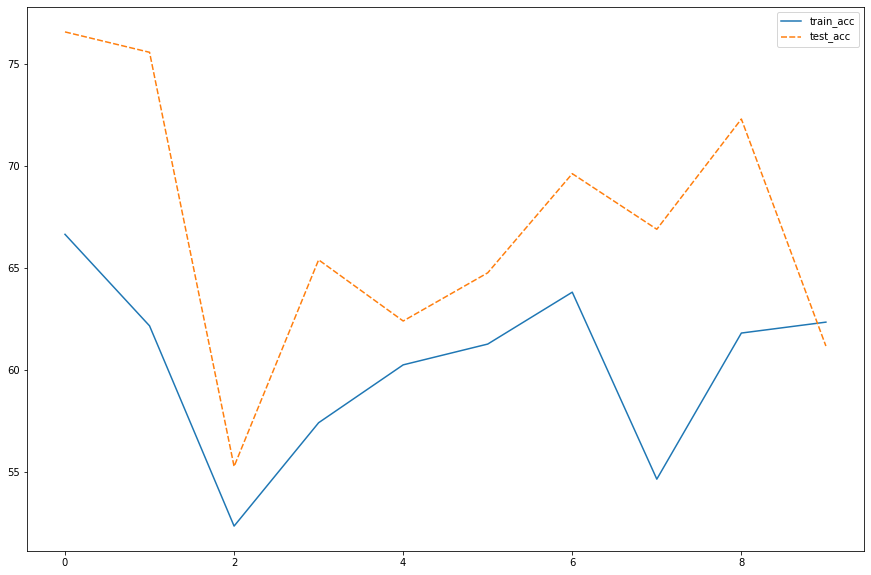

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


labels_font_size = 13
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=acc_hist)
# plt.xlabel("Typ danych", fontsize=labels_font_size)
# plt.ylabel("Dokładność zbioru walidacyjnego", fontsize=labels_font_size)
# plt.xticks(fontsize=labels_font_size) #rotation=10
# plt.yticks(fontsize=labels_font_size)
# plt.title('Dokładność zbioru walidacyjnego a typ danych', fontdict={'fontsize':20});

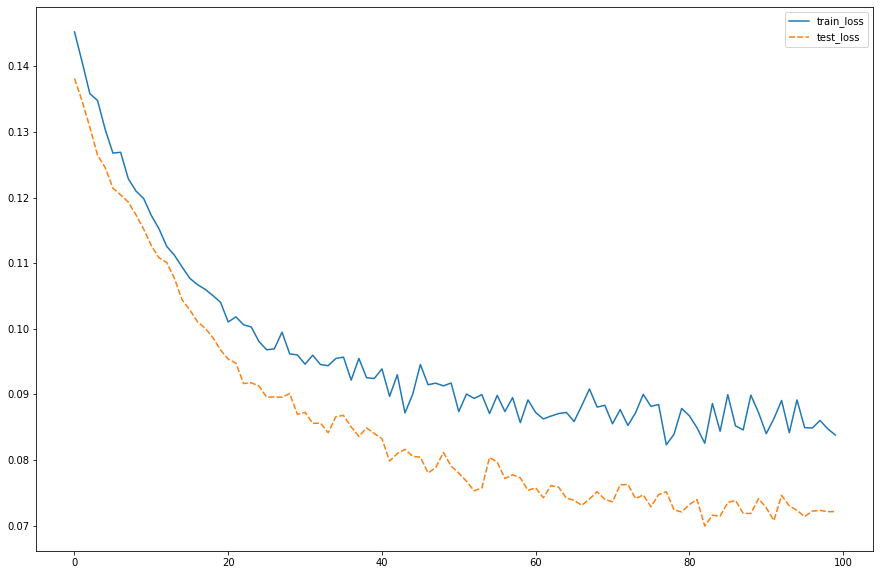

In [10]:
labels_font_size = 13
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=loss_hist)